# Homework 2 (Redo)

Name: Syed Zain Raza

## Setup Code

In [28]:
# optional: allow Jupyter to "hot reload" the Python modules I wrote, to avoid restarting the kernel after every change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from util import ops

In [6]:
dart_img = ops.load_image(
    "./Dartt3.png",
    return_array=True,
    return_grayscale=True,
)

Dimensions of ./Dartt3.png: 556 x 640


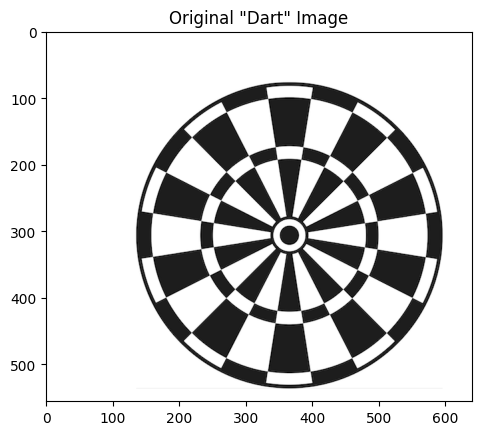

In [15]:
plt.imshow(dart_img, cmap="gray")
plt.title("Original \"Dart\" Image")
plt.show()

## Problem 1: Edge Detection

In [30]:
from util.gaussian_derivative import GaussianDerivativeFilter

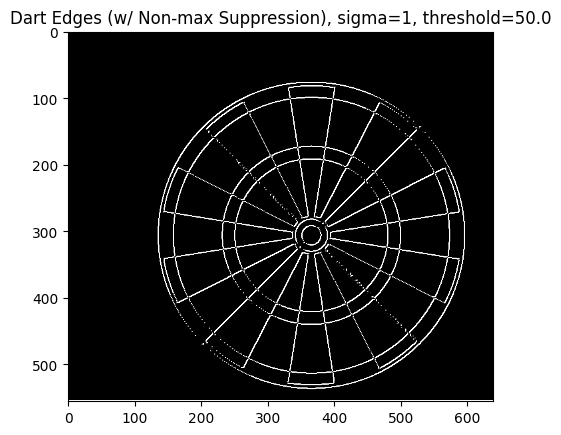

In [12]:
output_image = GaussianDerivativeFilter.detect_edges_and_visualize(
    image=dart_img,
    image_name="Dart",
    sigma=1,  # default
    threshold=50.0,
    use_non_max_suppression=True,
    padding_type="zero",
)

## Center Center Detection

### Problem 2: Hough Transform Voting of Edges Belonging to the Circles 

In [118]:
from util.model_fitting import HoughTransformCircleCenterDetector

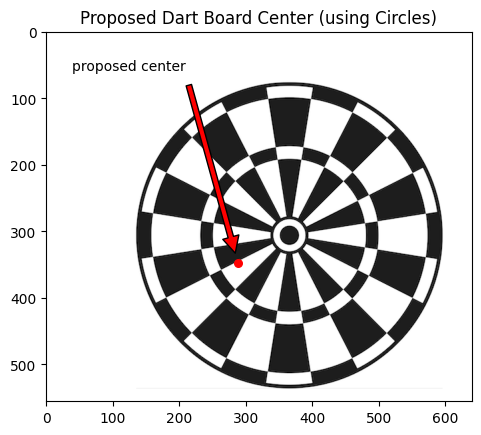

In [119]:
filter = GaussianDerivativeFilter()
(
    partial_derivative_y,
    partial_derivative_x,
) = filter._compute_derivatives(dart_img)
orientation_image = np.arctan2(partial_derivative_y, partial_derivative_x)
HoughTransformCircleCenterDetector.fit_and_report_using_circles(
    dart_img,
    output_image,
    orientation_image,
    radius_interval=(7, 12),
    plot_title="Proposed Dart Board Center (using Circles)",
)

Looks like we got close. With more time I believe I could improve this by tuning the `radius_interval`.

### Problem 3: Hough Transform Voting of Edges Belonging to the Straight Lines 

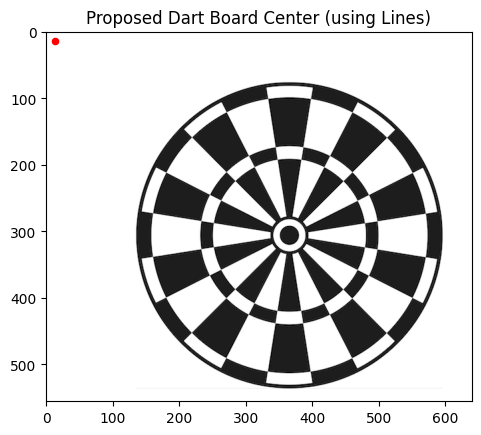

In [104]:
HoughTransformCircleCenterDetector.fit_and_report(
    dart_img,
    output_image,
    orientation_image,
    radius_interval=(9, 17),
    plot_title="Proposed Dart Board Center (using Lines)",
    mode="use_lines",  # or, can be "use_lines"
)

For this I'm not as sure what went wrong - perhaps the implementation has a bug...